<a href="https://colab.research.google.com/github/aditya161989/EIP4.0/blob/master/Copy_of_Baseline_1_Assignment_4B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Install required libraries

In [0]:
# Imports

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, SpatialDropout2D, UpSampling2D, GlobalAveragePooling2D, AveragePooling2D
import numpy as np
import os

In [0]:
# Initialize model parameters

# Training parameters
batch_size = 512  # orig paper trained all networks with batch_size=128
epochs = 50
data_augmentation = True
num_classes = 10

n = 6

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

weight_decay = 4e-3

In [40]:
# Load and preprocess data

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_test_grad = x_test

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Define RESNET layer

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = SeparableConv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(weight_decay))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
# Define RESNET V2

def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
# Prepare model

model = resnet_v2(input_shape=input_shape, depth=depth)
model.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 16)   91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________

In [0]:
# Cut out implementation

# p : the probability that random erasing is performed
# s_l, s_h : minimum / maximum proportion of erased area against input image
# r_1, r_2 : minimum / maximum aspect ratio of erased area
# v_l, v_h : minimum / maximum value for erased area
# pixel_level : pixel-level randomization for erased area

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [11]:
# Compile and run model

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.95),
              metrics=['accuracy'])

def scheduler(epoch, lr): #Implements cyclical learning rate
  step_size = 2300 #One triangle is completed at the 46th epoch and the learning rate remains the base rate for the rest 4 epochs
  iterations = epoch * 100
  base_lr = .1 #base learning rate
  max_lr = 1.5 #max learning rate
  cycle = np.floor(1+iterations/(2*step_size))
  x = np.abs(iterations/step_size - 2*cycle + 1)
  new_lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
  print((lr, new_lr))
  if(round(lr, 2) <= base_lr and epoch > 1):
    return base_lr 
  else:
    return new_lr

datagen = ImageDataGenerator(
                              # set input mean to 0 over the dataset
                              featurewise_center=False,
                              # set each sample mean to 0
                              samplewise_center=False,
                              # divide inputs by std of dataset
                              featurewise_std_normalization=False,
                              # divide each input by its std
                              samplewise_std_normalization=False,
                              # apply ZCA whitening
                              zca_whitening=False,
                              # epsilon for ZCA whitening
                              zca_epsilon=1e-06,
                              # randomly rotate images in the range (deg 0 to 180)
                              rotation_range=0,
                              # randomly shift images horizontally
                              width_shift_range=0.1,
                              # randomly shift images vertically
                              height_shift_range=0.1,
                              # set range for random shear
                              shear_range=0.,
                              # set range for random zoom
                              zoom_range=0.,
                              # set range for random channel shifts
                              channel_shift_range=0.,
                              # set mode for filling points outside the input boundaries
                              fill_mode='nearest',
                              # value used for fill_mode = "constant"
                              cval=0.,
                              # randomly flip images
                              horizontal_flip=True,
                              # randomly flip images
                              vertical_flip=False,
                              # set rescaling factor (applied before any other transformation)
                              rescale=None,
                              # set function that will be applied on each input
                              preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                              # image data format, either "channels_first" or "channels_last"
                              data_format=None,
                              # fraction of images reserved for validation (strictly between 0 and 1)
                              validation_split=0.0)

datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=[LearningRateScheduler(scheduler, verbose=1)])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
(0.009999999776482582, 0.1)

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
98/98 [==============================] - 53s 539ms/step - loss: 1.8654 - acc: 0.3096 - val_loss: 8.8256 - val_acc: 0.1684
Epoch 2/50
(0.10000000149011612, 0.16086956521739126)

Epoch 00002: LearningRateScheduler setting learning rate to 0.16086956521739126.
98/98 [==============================] - 35s 359ms/step - loss: 1.4563 - acc: 0.4683 - val_loss: 11.2000 - val_acc: 0.1132
Epoch 3/50
(0.1608695685863495, 0.22173913043478252)

Epoch 00003: LearningRateScheduler setting learning rate to 0.22173913043478252.
98/98 [==============================] - 35s 361ms/step - loss: 1.2671 - acc: 0.5453 - val_loss: 12.6447 - val_acc: 0.1158
Epoch 4/50
(0.22173912823200226, 0.2826086956521738)

Epoch 00004: LearningRateScheduler setting learning rate to 0.2826086956521738.
98/98 [=================

In [0]:
# Imports for Gradcam

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
# from cv2 import cv2_imshow
from google.colab.patches import cv2_imshow

(10, 32, 32, 3)
(10, 10)


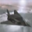

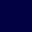

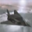

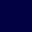

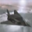

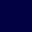

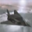

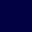

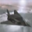

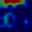

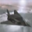

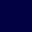

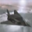

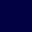

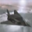

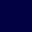

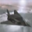

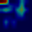

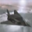

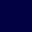

In [64]:

x_batch = x_test[0:10, : :]
print(x_batch.shape)
predict = model.predict_on_batch(x_batch)
print(predict.shape)
np.seterr(divide='ignore', invalid='ignore')
last_conv_layer = model.get_layer('activation_55')

for i in range(10):
  x = x_test_grad[i]
  
  x = np.expand_dims(x, axis=0)
  # print(x.shape)
  x = preprocess_input(x)
  class_idx = np.argmax(predict[i])
  class_output = model.output[:, class_idx]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  # print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(pooled_grads.shape[0]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  # print(conv_layer_output_value.shape)
  # print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (32, 32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  # print(x_test[i].shape)
  # print(heatmap.shape)
  superimposed_img = cv2.addWeighted(x_test[i], 0.5, heatmap, 0.5, 0, dtype = cv2.CV_32F)

  cv2_imshow(x_test_grad[i])
  cv2_imshow(superimposed_img)
